In [15]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

In [16]:
# case can be "rgb_rad, rgb_angle, depth_rad or depth_angle"

case = 'rgb_angle'

ves = 0

In [17]:
if case.split('_')[1] == 'rad':
        classes_num = 6
elif case.split('_')[1] == 'angle':
        classes_num = 16
else:
        print ('error "case" not defined')

In [18]:
def get_model(weights_path, case):
    model = torchvision.models.resnet18(pretrained=True, progress=True)

    if case.split('_')[0] == 'depth':
        model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    model.fc = nn.Linear(512, classes_num)
    model.eval()


    model.load_state_dict(torch.load(weights_path))
    cmap_model = SmoothGradCAMpp(model)
    
    return model, cmap_model

def mask (rgb, depth):
    
    mask = cv.cvtColor(depth, cv.COLOR_BGR2GRAY)
    _, mask = cv.threshold(mask, 100, 255, cv.THRESH_BINARY)
    masked_rgb = cv.bitwise_and(rgb, rgb, mask = mask.astype('uint8'))
    
    return masked_rgb

def im2tens(rgb, depth):
        
        rgb_transform = torchvision.transforms.ToTensor()
        depth_transform = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels=1)])
                 
        rgb_tensor = rgb_transform(rgb)
        depth_tensor = depth_transform(depth)

        return rgb_tensor, depth_tensor

def activation_map(img, map_img, model, cmap_model, device):
    
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get prediction from model
    yb = model(xb.to(device))
    # Get the normalized probability vector
    activation_map = cmap_model(yb.squeeze(0).argmax().item(), yb)
    result = overlay_mask(to_pil_image(map_img), to_pil_image(activation_map[0], mode='F'), alpha=0.5)
    
    return result

def plot(imgs):
    
    fig, ax = plt.subplots(len(imgs)//3,3, figsize=(15, 15))
    
    for ii in range(len(imgs)):
            ax[ii].imshow(imgs[ii])
            ax[ii].set_axis_off()
            

In [19]:
rgb_img_dir = './dataset/AC_map/rgb/'
depth_img_dir = './dataset/AC_map/depth/'
weights_path = './Weights/' + case + '_v' + str(ves) + '.pth'

model, cmap_model =  get_model(weights_path, case)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


C_maps = []
for img_name in os.listdir(rgb_img_dir):
    rgb = cv.cvtColor(cv.imread(rgb_img_dir + img_name), cv.COLOR_BGR2RGB)
    depth = cv.cvtColor(cv.imread(depth_img_dir + img_name), cv.COLOR_BGR2RGB)
    masked_rgb = mask (rgb, depth)
    rgb_tensor, depth_tensor = im2tens(rgb, depth)
    masked_rgb_tensor, _ = im2tens(masked_rgb, depth)

    activation_img = activation_map(masked_rgb_tensor, rgb_tensor, model, cmap_model, device)
    C_maps.append(activation_img)


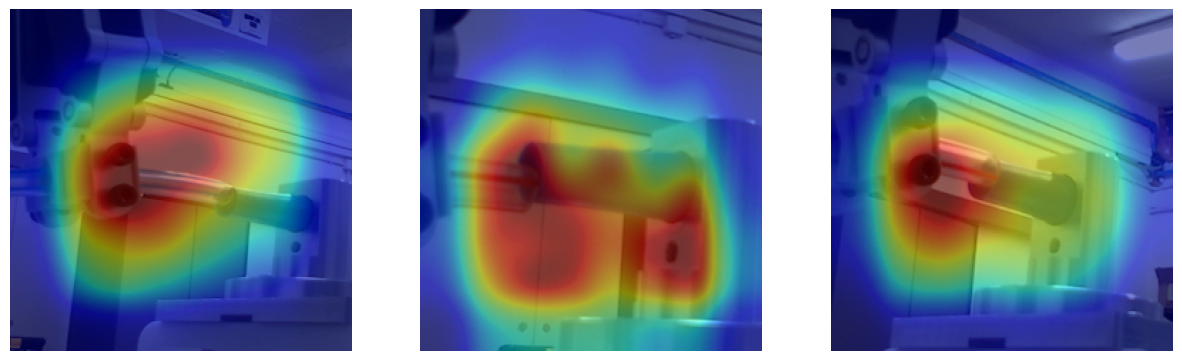

In [20]:
plot(C_maps)